## setting

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)
        self.fc3.weight.detach().uniform_(-1, 1)
        self.fc3.bias.detach().uniform_(-1, 1)
        self.fc4.weight.detach().uniform_(-1,1)





        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        out = self.fc3(out)
        out = out/np.sqrt(hidden_size2)
        out = self.relu2(out)
        out = self.fc4(out)
        out = out/np.sqrt(hidden_size3)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

## Original Training

In [ ]:
out=[]
for p in [-1,0,1]:
    print(p)
    learning_rate = 1
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-1:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    num_epochs=700
    dev=100
    losslist=[]
    aclist=[]


    totalloss=[]


    model.fc2.register_forward_hook(get_activation('fc2'))

    count=0
    dd=10
    de=1

    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):
                        

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            if count<10:
                print(count,loss.item())

            
            
            
            

            if ad and (p>0):
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        ac=accuracy(model,valloader)
        aclist.append(ac)
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.01:
            break
    out.append([losslist,totalloss,aclist])

-1
0 0.11053480207920074
1 0.10921716690063477
2 0.11208365112543106
3 0.10695278644561768
4 0.10968738049268723
5 0.10966236889362335
6 0.10733737796545029
7 0.10607334226369858
8 0.10503989458084106
9 0.10538293421268463
Accuracy: 78.1100 %
Epoch [1/700], Loss: 0.0660
Accuracy: 85.5700 %
Epoch [2/700], Loss: 0.0425
Accuracy: 88.1700 %
Epoch [3/700], Loss: 0.0341
Accuracy: 89.6600 %
Epoch [4/700], Loss: 0.0290
Accuracy: 90.6800 %
Epoch [5/700], Loss: 0.0256
Accuracy: 91.4500 %
Epoch [6/700], Loss: 0.0231
Accuracy: 91.9200 %
Epoch [7/700], Loss: 0.0213
Accuracy: 92.3400 %
Epoch [8/700], Loss: 0.0199
Accuracy: 92.7500 %
Epoch [9/700], Loss: 0.0188
Accuracy: 93.0400 %
Epoch [10/700], Loss: 0.0178
Accuracy: 93.4400 %
Epoch [11/700], Loss: 0.0170
Accuracy: 93.6400 %
Epoch [12/700], Loss: 0.0163
Accuracy: 93.8900 %
Epoch [13/700], Loss: 0.0156
Accuracy: 94.1300 %
Epoch [14/700], Loss: 0.0150
Accuracy: 94.3200 %
Epoch [15/700], Loss: 0.0145
Accuracy: 94.5000 %
Epoch [16/700], Loss: 0.0140
Ac

Text(0.5, 0, 'Step')

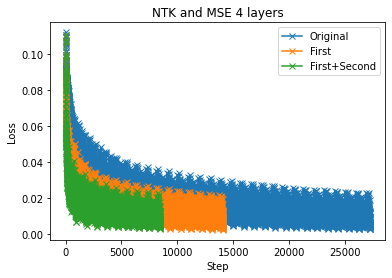

In [ ]:
plt.plot(out[0][1],'x-',label='Original')
plt.plot(out[1][1],'x-',label='First')
plt.plot(out[2][1],'x-',label='First+Second')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('NTK and MSE 4 layers')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 0, 'Step')

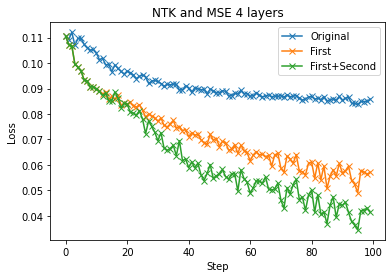

In [ ]:
plt.plot(out[0][1][:100],'x-',label='Original')
plt.plot(out[1][1][:100],'x-',label='First')
plt.plot(out[2][1][:100],'x-',label='First+Second')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('NTK and MSE 4 layers')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 0, 'Epoch')

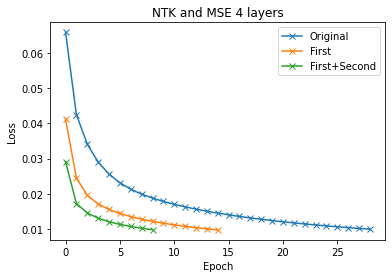

In [ ]:
plt.plot(out[0][0],'x-',label='Original')
plt.plot(out[1][0],'x-',label='First')
plt.plot(out[2][0],'x-',label='First+Second')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('NTK and MSE 4 layers')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

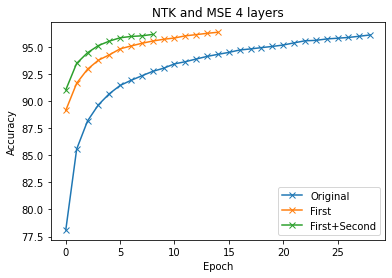

In [ ]:
plt.plot(out[0][2],'x-',label='Original')
plt.plot(out[1][2],'x-',label='First')
plt.plot(out[2][2],'x-',label='First+Second')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('NTK and MSE 4 layers')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

## Two layers

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
learning_rate = 1
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)              
eigenvalueo=eig[0][:,0].cpu().data.detach().numpy()

In [ ]:
learning_rate = 1
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=2)





H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()

tensor([ 0.1000,  0.1567,  0.1000,  0.1000,  0.3139,  0.4436,  0.5712,  1.8480,
         0.1864,  0.2028,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
         0.1000,  0.1000,  0.1000,  0.3461,  0.8189,  0.1487,  0.2685,  0.1000,
         0.1860,  0.1000,  0.3623,  0.1206,  0.8006,  0.1000,  0.1000,  0.1000,
         0.2463,  0.1000,  2.7584,  0.1000,  0.1447,  0.1367,  0.1000,  0.1000,
         0.2109, 10.0000,  0.3442,  0.3172,  0.1000,  0.1297,  0.2128,  0.1040,
         0.1000,  3.7278,  1.7510,  0.1000,  1.5385,  0.1046,  2.1205,  0.5728,
         0.8983, 10.0000,  0.1321,  2.3104,  1.9561,  0.1000,  0.1346,  0.1317,
        10.0000,  0.8556,  0.1000, 10.0000,  0.2921,  0.2376,  0.1398,  0.6379,
         0.1154,  2.1595,  0.1000,  0.7355,  0.7194,  0.1819,  0.6107,  3.8285,
         0.1000,  0.1612,  1.2446,  0.1091,  0.3259,  0.1000,  0.6331,  1.5718,
         0.1000,  0.1000,  0.1000,  0.4303,  0.1000,  0.7474,  0.1000, 10.0000,
         0.8333,  0.1126,  0.1000,  0.10

Text(0.5, 0, 'Eigenvalue index')

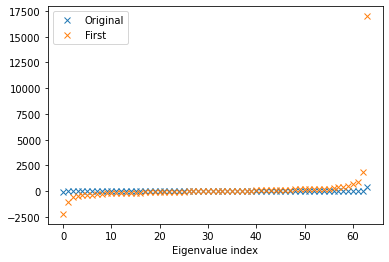

In [ ]:
plt.plot(np.sort(eigenvalueo),'x',label='Original')
plt.plot(np.sort(eigenvaluem),'x',label='First')
plt.legend()
plt.xlabel('Eigenvalue index')

## 4 layers(Original)

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


### original

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)              
eigenvalueo=eig[0][:,0].cpu().data.detach().numpy()

### first

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)


for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem1=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154


### second

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)
labels =one_hot(labels,num_classes).to(device)
adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


model.fc2.register_forward_hook(get_activation('fc2'))
output = model(images)
adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=3,oflag=1)  

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())




for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem2=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19


Text(0.5, 0, 'Eigenvalue index')

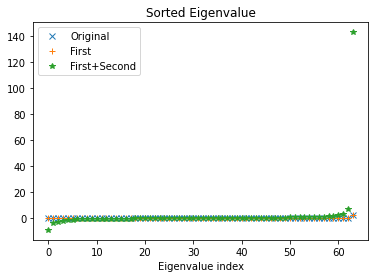

In [ ]:
plt.plot(np.sort(eigenvalueo),'x',label='Original')
plt.plot(np.sort(eigenvaluem1),'+',label='First')
plt.plot(np.sort(eigenvaluem2),'*',label='First+Second')
plt.title('Sorted Eigenvalue')
plt.legend()
plt.xlabel('Eigenvalue index')

## 4 layers(iterated)

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.relu2(out)
        out = self.fc4(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


### original

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)



for itera in range(100):
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)              
eigenvalueo=eig[0][:,0].cpu().data.detach().numpy()

### first

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)



for itera in range(100):
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem1=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154


### second

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)
labels =one_hot(labels,num_classes).to(device)
adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

for itera in range(10):
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


model.fc2.register_forward_hook(get_activation('fc2'))
output = model(images)
adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=3,oflag=1)  

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())


for itera in range(90):
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem2=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 3, Kernel Nodes: 81, Adptive Nodes19


Text(0.5, 0, 'Eigenvalue index')

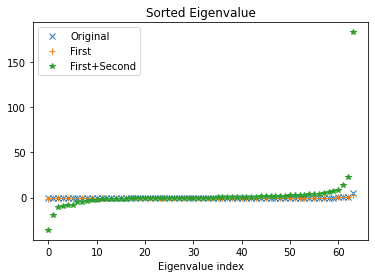

In [ ]:
plt.plot(np.sort(eigenvalueo),'x',label='Original')
plt.plot(np.sort(eigenvaluem1),'+',label='First')
plt.plot(np.sort(eigenvaluem2),'*',label='First+Second')
plt.title('Sorted Eigenvalue')
plt.legend()
plt.xlabel('Eigenvalue index')

## 4 layers training

In [84]:
def iterstep(i):
    for k in range(i):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [85]:
def onestep():
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [87]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out
eigenvaluepolt=False
outputindex=1     
if eigenvaluepolt:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)

    H=torch.zeros([batch_size,batch_size])
    numberparameter=len(model.state_dict())
    for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        labelo=outputs.clone()
        labelo[outputindex]=label[outputindex]
        loss = criterion(outputs, labelo).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        deff=label[outputindex]-outputs[outputindex]
        for p in model.parameters():
            Pigrad.append(p.grad.detach()/deff*10)
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[i].to(device)
            labelo=outputs.clone()
            labelo[outputindex]=label[outputindex]
            loss = criterion(outputs, labelo).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            deff=label[outputindex]-outputs[outputindex]
            for p in model.parameters():
                Pjgrad.append(p.grad.detach()/deff*10)
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
    eig=torch.eig(H)
               
    eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
    print(np.sum(eigenvaluem))
    plt.hist(eigenvaluem, bins=50) 
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('eigenvalue')
    plt.savefig('/content/drive/My Drive/LCNN/plot/LCNNspec.pdf')


In [41]:
out=[]

for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(1000*20):
        if runsteps %10000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach())
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[j]
                        loss = criterion(outputs, label).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach())
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)
        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])


NameError: ignored

Text(0.5, 0, 'Step')

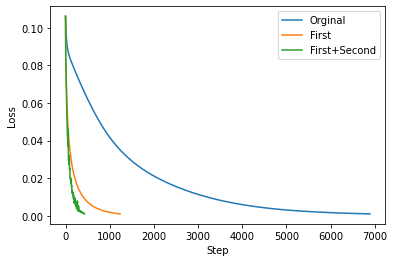

In [ ]:
plt.plot(out[0][0],'-',label='Orginal')
plt.plot(out[1][0],'-',label='First')
plt.plot(out[2][0],'-',label='First+Second')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')


In [88]:
out=[]

for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(400):
        if runsteps %20==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    labelo=outputs.clone()
                    labelo[outputindex]=label[outputindex]
                    loss = criterion(outputs, labelo).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    deff=label[outputindex]-outputs[outputindex]
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach()/deff*10)
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[i].to(device)
                        labelo=outputs.clone()
                        labelo[outputindex]=label[outputindex]
                        loss = criterion(outputs, labelo).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        deff=label[outputindex]-outputs[outputindex]
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach()/deff*10)
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)


        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)



        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])


0 0 0.10614407062530518
0 100 0.0838378295302391
0 200 0.07799194008111954
0 300 0.07230466604232788
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
1 0 0.10614407062530518
1 100 0.03473510965704918
1 200 0.020902398973703384
1 300 0.014074272476136684
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
2 0 0.10614407062530518
Adjusting Layer 3, Kernel Nodes: 94, Adptive Nodes6
2 100 0.021579252555966377
2 200 0.007401715498417616
2 300 0.0034927332308143377


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

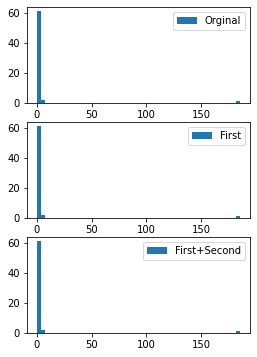

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

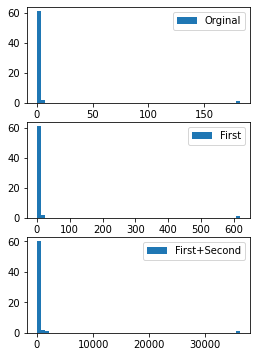

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

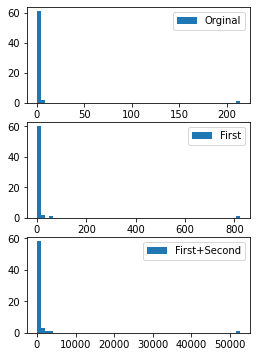

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

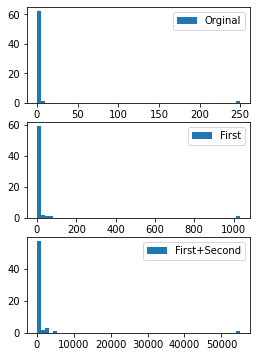

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

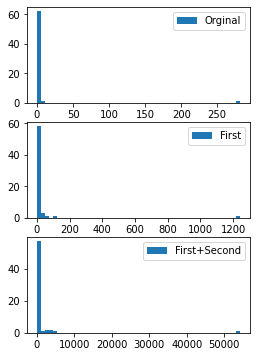

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

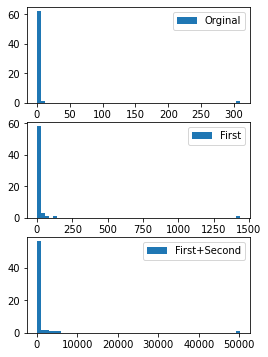

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

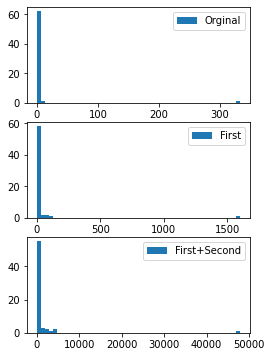

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

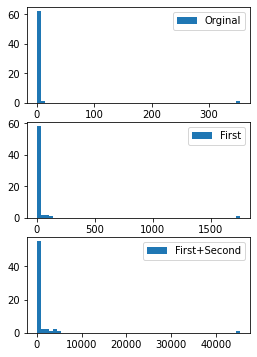

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

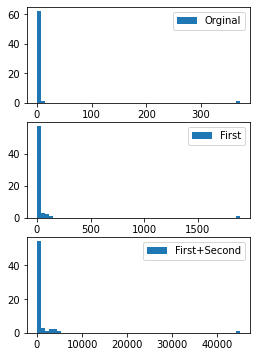

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

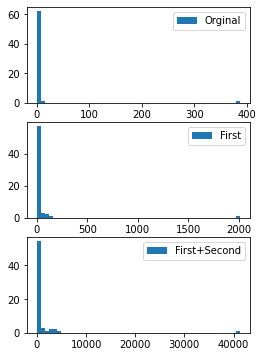

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

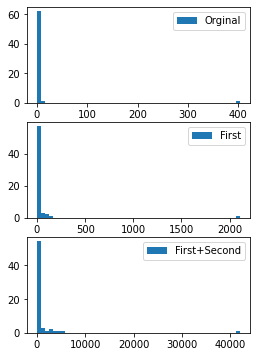

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

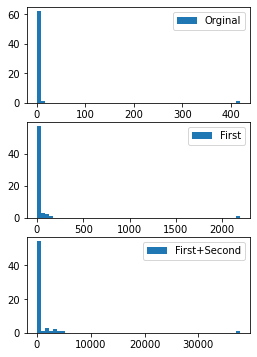

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

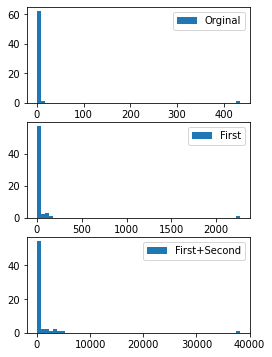

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

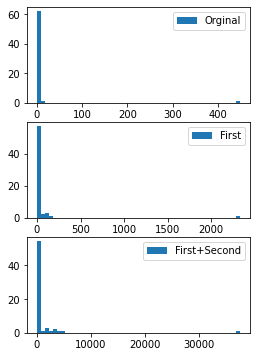

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

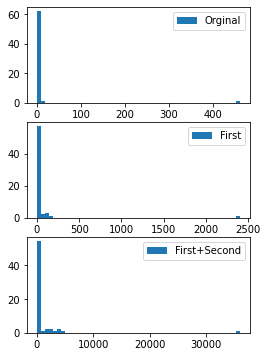

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

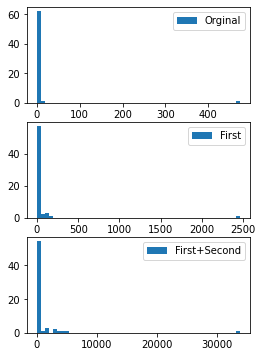

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

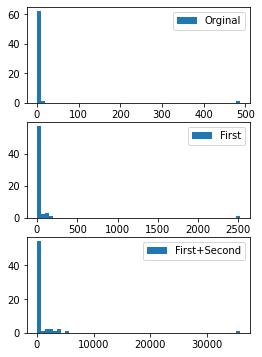

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

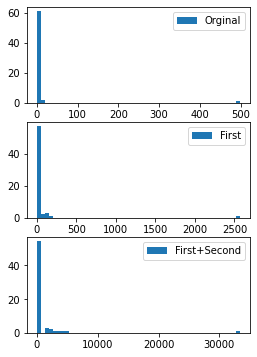

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

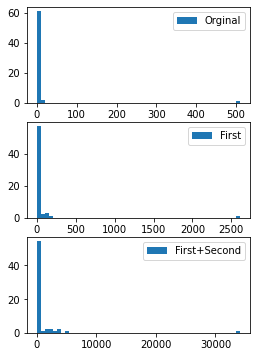

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

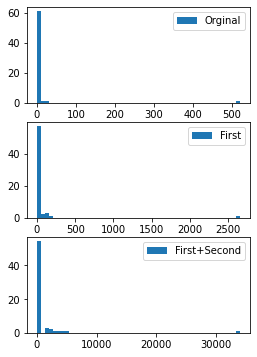

<IPython.core.display.Javascript object>

In [90]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*20) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):


        f = plt.figure(figsize=(4,6))
        ax = f.add_subplot(311)
        ax2 = f.add_subplot(312)
        ax3 = f.add_subplot(313)



        ax.hist(out[0][1][i], bins=50,label='Orginal')
        ax.legend()

        ax2.hist(out[1][1][i], bins=50,label='First')
        ax2.legend()

        ax3.hist(out[2][1][i], bins=50,label='First+Second')
        ax3.legend()

        plt.savefig('/content/drive/My Drive/LCNN/plot/4LCNNspectrum/'+str(i)+'.pdf')


    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

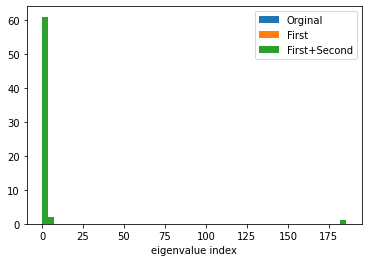

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

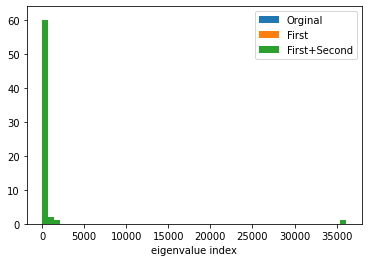

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

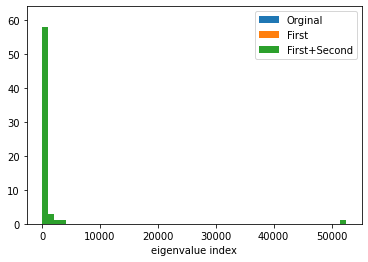

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

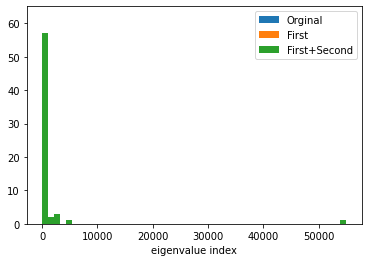

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

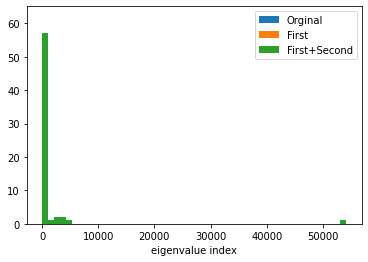

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

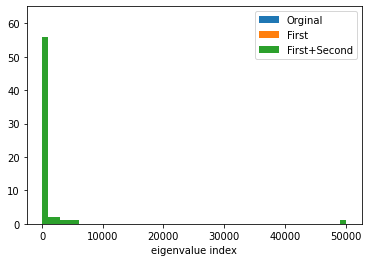

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

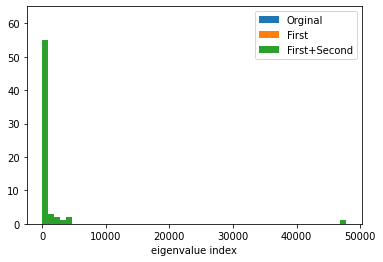

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

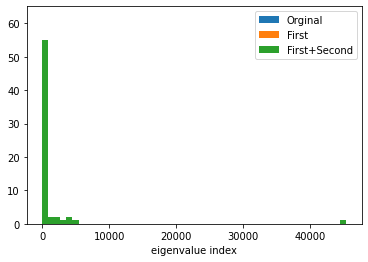

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

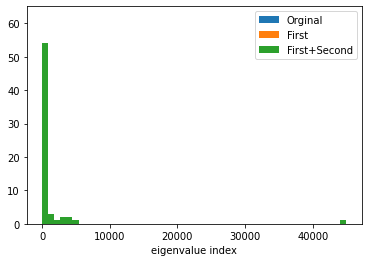

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

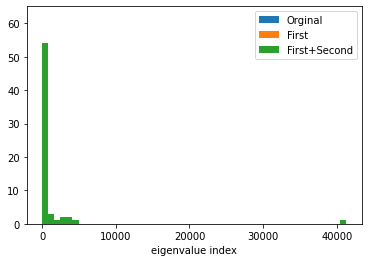

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

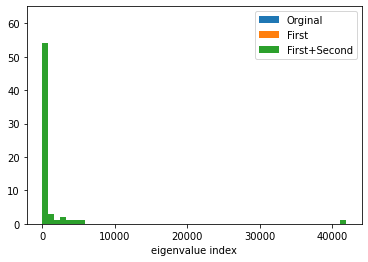

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

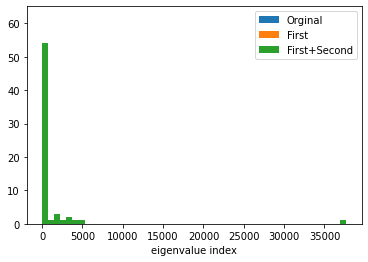

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

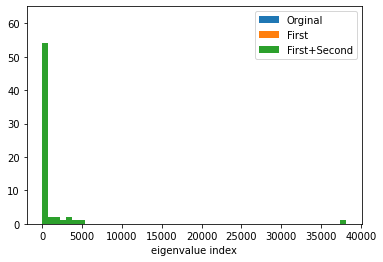

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

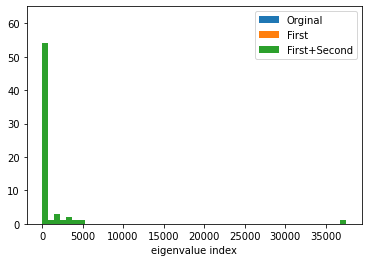

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

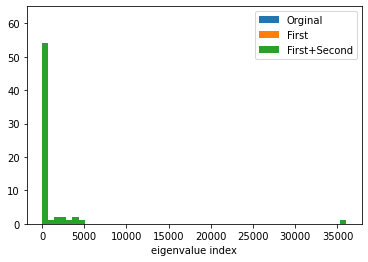

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

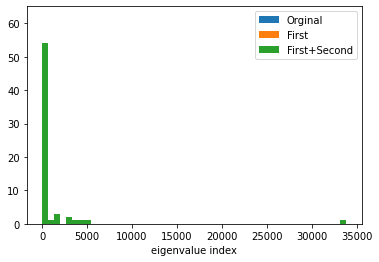

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

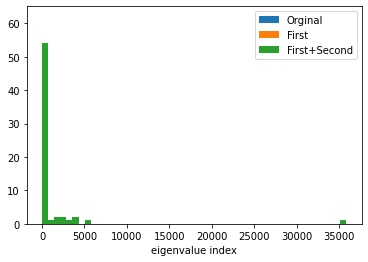

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

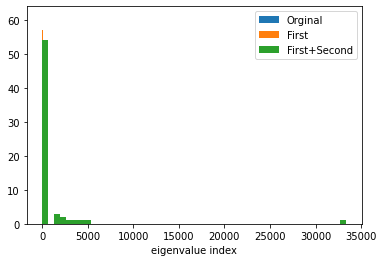

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

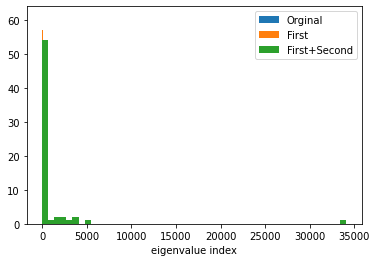

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

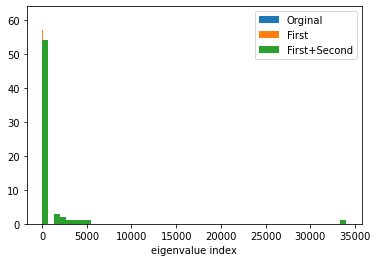

<IPython.core.display.Javascript object>

In [67]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*20) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):



        plt.hist(out[0][1][i], bins=50,label='Orginal')
        plt.hist(out[1][1][i], bins=50,label='First')
        plt.hist(out[2][1][i], bins=50,label='First+Second')
        #plt.plot(np.sort(out[0][1][i]),'x',label='Orginal')
        #plt.plot(np.sort(out[1][1][i]),'x',label='First')
        #plt.plot(np.sort(out[2][1][i]),'x',label='First+Second')
        plt.legend()

        plt.xlabel('eigenvalue index')


    plt.show()

In [ ]:
out=[]

for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(40):
        if runsteps %2==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach())
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[j]
                        loss = criterion(outputs, label).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach())
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)


        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)



        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])


0 0 0.10614407062530518
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
1 0 0.10614407062530518
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
2 0 0.10614407062530518
Adjusting Layer 3, Kernel Nodes: 94, Adptive Nodes6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

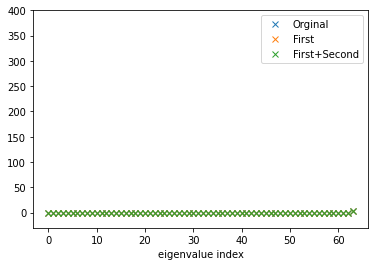

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

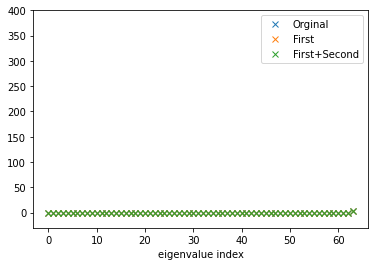

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

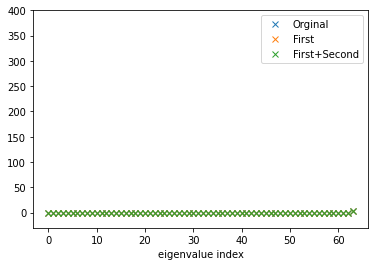

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

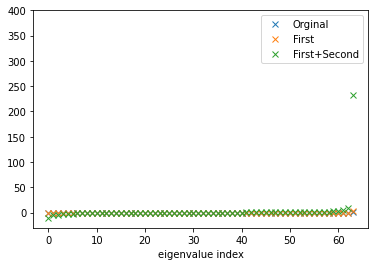

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

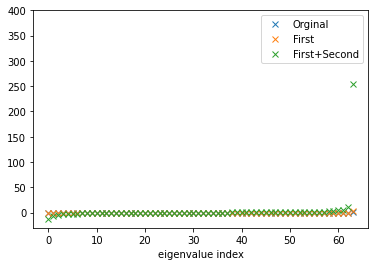

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

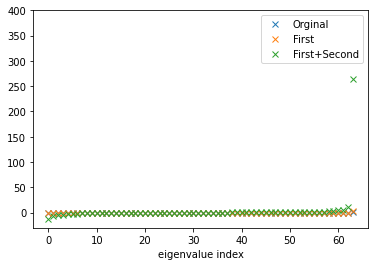

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

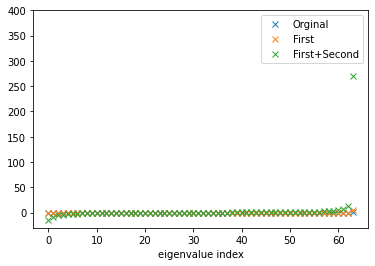

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

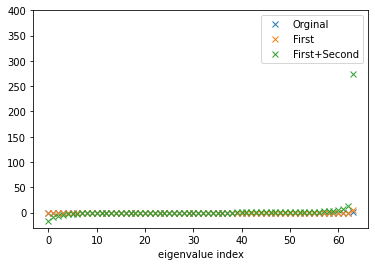

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

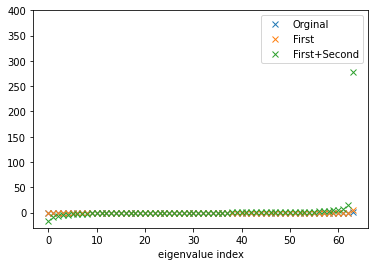

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

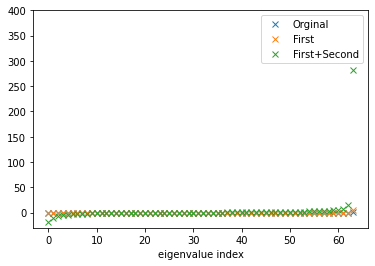

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

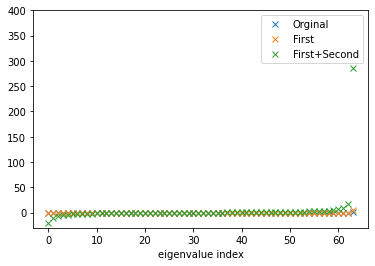

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

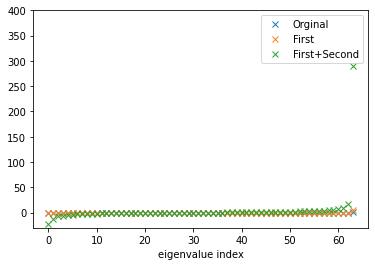

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

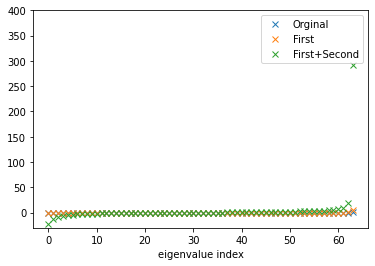

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

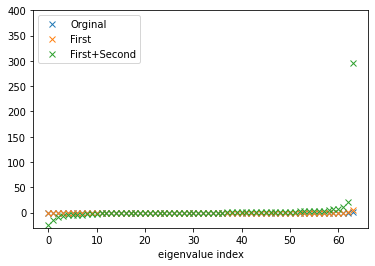

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

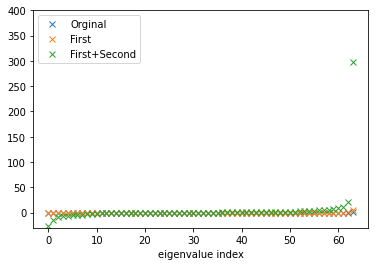

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

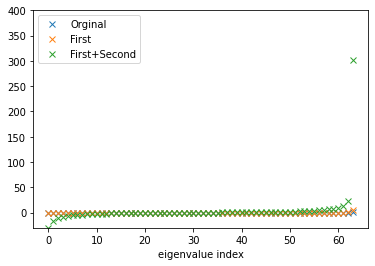

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

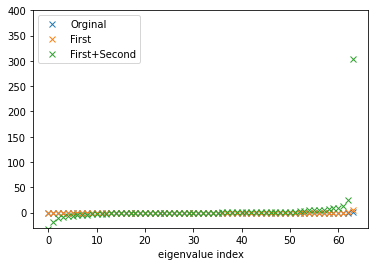

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

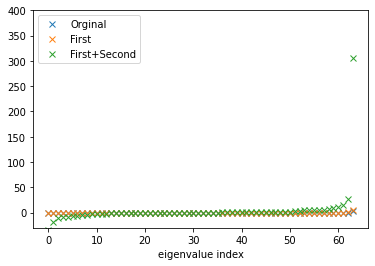

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

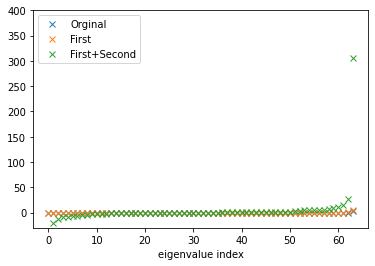

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

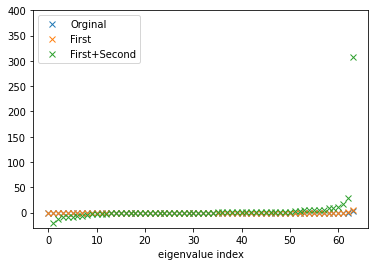

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*2) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):
        plt.plot(np.sort(out[0][1][i]),'x',label='Orginal')
        plt.plot(np.sort(out[1][1][i]),'x',label='First')
        plt.plot(np.sort(out[2][1][i]),'x',label='First+Second')
        plt.legend()
        plt.ylim([-30,400])
        plt.xlabel('eigenvalue index')

    plt.show()

## 4 layers coupled (iterstep)

In [ ]:
def iterstep(i):
    for k in range(i):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


### original

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)
iterstep(40)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)              
eigenvalueo=eig[0][:,0].cpu().data.detach().numpy()

### first

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)
iterstep(40)


for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem1=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154


### second + third

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)
labels =one_hot(labels,num_classes).to(device)
adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

iterstep(10)
model.fc1.register_forward_hook(get_activation('fc1'))
output = model(images)
adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1)  

iterstep(10)
model.fc2.register_forward_hook(get_activation('fc2'))
output = model(images)
adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=3,oflag=1)  

iterstep(10)
H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())


iterstep(10)
for itera in range(10):
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem2=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 2, Kernel Nodes: 131, Adptive Nodes69
Adjusting Layer 3, Kernel Nodes: 94, Adptive Nodes6


Text(0.5, 0, 'Eigenvalue index')

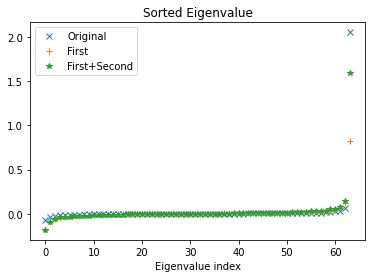

In [ ]:
plt.plot(np.sort(eigenvalueo),'x',label='Original')
plt.plot(np.sort(eigenvaluem1),'+',label='First')
plt.plot(np.sort(eigenvaluem2),'*',label='First+Second')
plt.title('Sorted Eigenvalue')
plt.legend()
plt.xlabel('Eigenvalue index')

## 4 layers coupled (Original)

In [ ]:
def iterstep(i):
    for k in range(i):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


### original

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)
#iterstep(40)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)              
eigenvalueo=eig[0][:,0].cpu().data.detach().numpy()

### first

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)
#iterstep(40)


for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem1=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154


### second + third

In [ ]:
learning_rate = 0.01
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)
labels =one_hot(labels,num_classes).to(device)
adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

#iterstep(10)
model.fc1.register_forward_hook(get_activation('fc1'))
output = model(images)
adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1)  

#iterstep(10)
model.fc2.register_forward_hook(get_activation('fc2'))
output = model(images)
adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=3,oflag=1)  

#iterstep(10)
H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())


#iterstep(10)
for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvaluem2=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
Adjusting Layer 2, Kernel Nodes: 139, Adptive Nodes61
Adjusting Layer 3, Kernel Nodes: 78, Adptive Nodes22


Text(0.5, 0, 'Eigenvalue index')

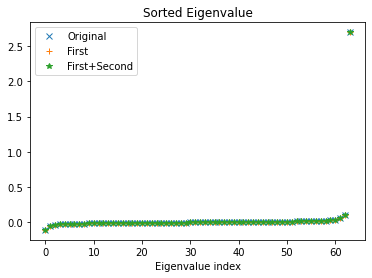

In [ ]:
plt.plot(np.sort(eigenvalueo),'x',label='Original')
plt.plot(np.sort(eigenvaluem1),'+',label='First')
plt.plot(np.sort(eigenvaluem2),'*',label='First+Second')
plt.title('Sorted Eigenvalue')
plt.legend()
plt.xlabel('Eigenvalue index')

## 4 layers coupled training

In [34]:
def iterstep(i):
    for k in range(i):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [35]:
def onestep():
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

No handles with labels found to put in legend.


256.00006


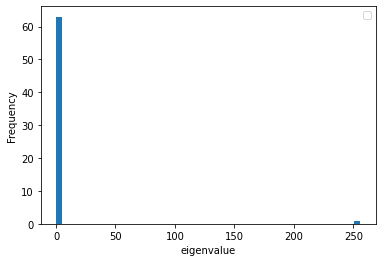

In [101]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

eigenvaluepolt=True
outputindex=1     
if eigenvaluepolt:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)

    H=torch.zeros([batch_size,batch_size])
    numberparameter=len(model.state_dict())
    for i in range(batch_size):
            image=images[i]
            outputs = model(image).to(device)
            label=labels[i].to(device)
            labelo=outputs.clone()
            labelo[outputindex]=label[outputindex]
            loss = criterion(outputs, labelo).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pigrad=[]
            pindex=0
            deff=label[outputindex]-outputs[outputindex]
            for p in model.parameters():
                Pigrad.append(p.grad.detach()/deff*10)
            for j in range(i):
                image=images[j]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                labelo=outputs.clone()
                labelo[outputindex]=label[outputindex]
                loss = criterion(outputs, labelo).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pjgrad=[]
                pjndex=0
                deff=label[outputindex]-outputs[outputindex]
                for p in model.parameters():
                    Pjgrad.append(p.grad.detach()/deff*10)
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                    H[i][j]=ij
                    H[j][i]=ij
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                H[i][i]=ij
    eig=torch.eig(H)
               
    eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
    print(np.sum(eigenvaluem))
    plt.hist(eigenvaluem, bins=50) 
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('eigenvalue')
    plt.savefig('/content/drive/My Drive/LCNN/plot/NNspec.pdf')

In [102]:
adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154


No handles with labels found to put in legend.


256.00012


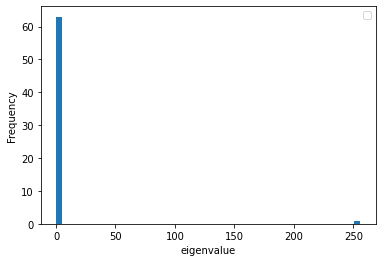

In [103]:
    H=torch.zeros([batch_size,batch_size])
    numberparameter=len(model.state_dict())
    for i in range(batch_size):
            image=images[i]
            outputs = model(image).to(device)
            label=labels[i].to(device)
            labelo=outputs.clone()
            labelo[outputindex]=label[outputindex]
            loss = criterion(outputs, labelo).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pigrad=[]
            pindex=0
            deff=label[outputindex]-outputs[outputindex]
            for p in model.parameters():
                Pigrad.append(p.grad.detach()/deff*10)
            for j in range(i):
                image=images[j]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                labelo=outputs.clone()
                labelo[outputindex]=label[outputindex]
                loss = criterion(outputs, labelo).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pjgrad=[]
                pjndex=0
                deff=label[outputindex]-outputs[outputindex]
                for p in model.parameters():
                    Pjgrad.append(p.grad.detach()/deff*10)
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                    H[i][j]=ij
                    H[j][i]=ij
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                H[i][i]=ij
    eig=torch.eig(H)
               
    eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
    print(np.sum(eigenvaluem))
    plt.hist(eigenvaluem, bins=50) 
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('eigenvalue')
    plt.savefig('/content/drive/My Drive/LCNN/plot/NNspec.pdf')

In [74]:
out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for prob in [0,1,2,3]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=0
    outputindex=1
    for runsteps in range(1000*20):
        if runsteps %1000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                image=images[i]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                labelo=outputs.clone()
                labelo[outputindex]=label[outputindex]
                loss = criterion(outputs, labelo).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pigrad=[]
                pindex=0
                deff=label[outputindex]-outputs[outputindex]
                for p in model.parameters():
                    Pigrad.append(p.grad.detach()/deff*10)
                for j in range(i):
                    image=images[j]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    labelo=outputs.clone()
                    labelo[outputindex]=label[outputindex]
                    loss = criterion(outputs, labelo).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pjgrad=[]
                    pjndex=0
                    deff=label[outputindex]-outputs[outputindex]
                    for p in model.parameters():
                        Pjgrad.append(p.grad.detach()/deff*10)
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                        H[i][j]=ij
                        H[j][i]=ij
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                    H[i][i]=ij

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


        if prob>1 and runsteps==de:
            model.fc1.register_forward_hook(get_activation('fc1'))
            output = model(images)
            adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1) 
        if prob>2 and runsteps==2*de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])


0 0 0.10569465160369873
0 100 0.08883868902921677
0 200 0.08253630250692368
0 300 0.07853171229362488
0 400 0.0750017985701561
0 500 0.07162363827228546
0 600 0.06835775077342987
0 700 0.0651361271739006
0 800 0.06191561371088028
0 900 0.058705300092697144


KeyboardInterrupt: ignored

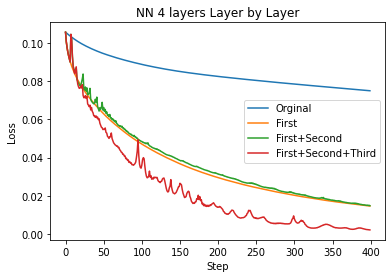

In [80]:
plt.plot(out[0][0],'-',label='Orginal')
plt.plot(out[1][0],'-',label='First')
plt.plot(out[2][0],'-',label='First+Second')
plt.plot(out[3][0],'-',label='First+Second+Third')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('NN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/123.pdf')

In [75]:
out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for prob in [0,1,2,3]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(400):
        if runsteps %20==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                image=images[i]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                labelo=outputs.clone()
                labelo[outputindex]=label[outputindex]
                loss = criterion(outputs, labelo).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pigrad=[]
                pindex=0
                deff=label[outputindex]-outputs[outputindex]
                for p in model.parameters():
                    Pigrad.append(p.grad.detach()/deff*10)
                for j in range(i):
                    image=images[j]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    labelo=outputs.clone()
                    labelo[outputindex]=label[outputindex]
                    loss = criterion(outputs, labelo).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pjgrad=[]
                    pjndex=0
                    deff=label[outputindex]-outputs[outputindex]
                    for p in model.parameters():
                        Pjgrad.append(p.grad.detach()/deff*10)
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                        H[i][j]=ij
                        H[j][i]=ij
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                    H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


        if prob>1 and runsteps==de:
            model.fc1.register_forward_hook(get_activation('fc1'))
            output = model(images)
            adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1) 
        if prob>2 and runsteps==2*de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])

0 0 0.10569465160369873
0 100 0.08883868902921677
0 200 0.08253630250692368
0 300 0.07853171229362488
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
1 0 0.10569465160369873
1 100 0.04708847403526306
1 200 0.029492726549506187
1 300 0.02024618349969387
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
2 0 0.10569465160369873
Adjusting Layer 2, Kernel Nodes: 134, Adptive Nodes66
2 100 0.0484742596745491
2 200 0.0314626507461071
2 300 0.02139142155647278
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
3 0 0.10569465160369873
Adjusting Layer 2, Kernel Nodes: 134, Adptive Nodes66
Adjusting Layer 3, Kernel Nodes: 84, Adptive Nodes16
3 100 0.03605430945754051
3 200 0.014082560315728188
3 300 0.0079031465575099


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

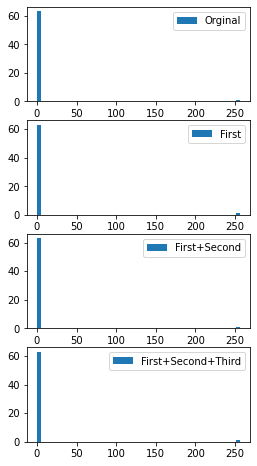

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

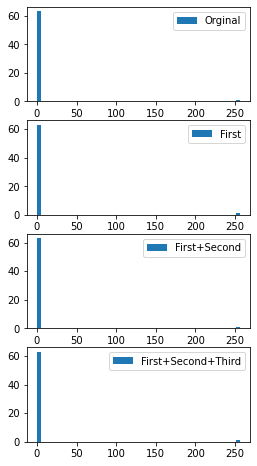

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

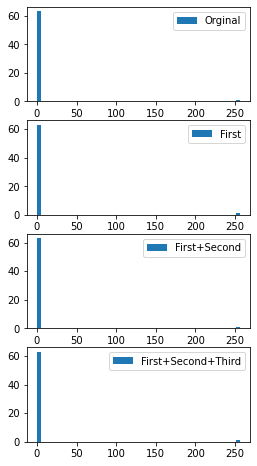

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

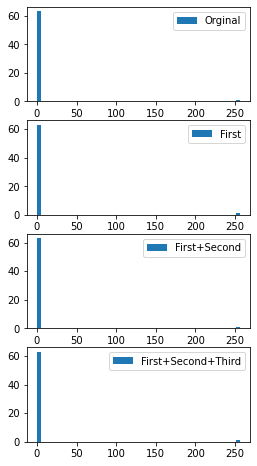

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

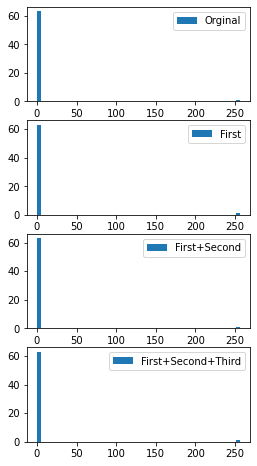

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

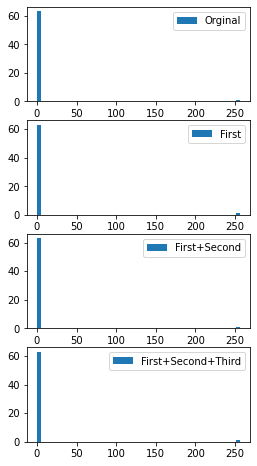

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

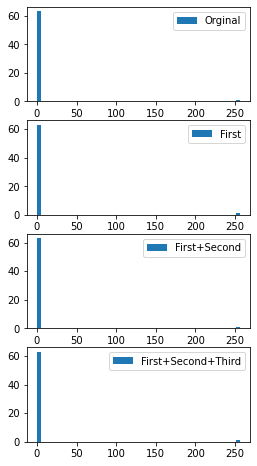

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

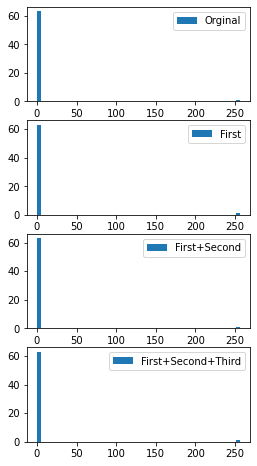

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

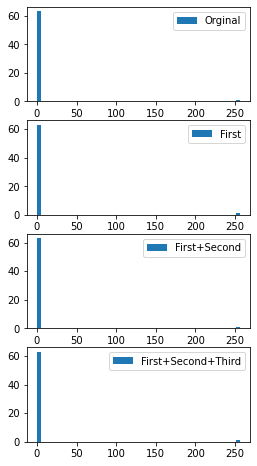

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

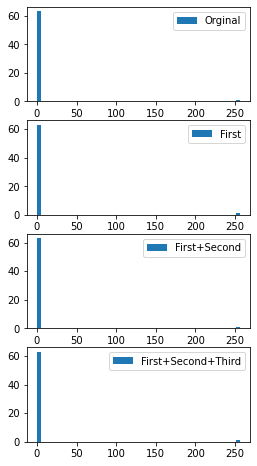

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

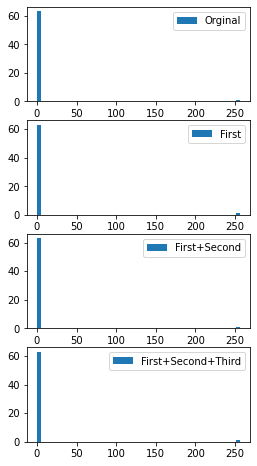

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

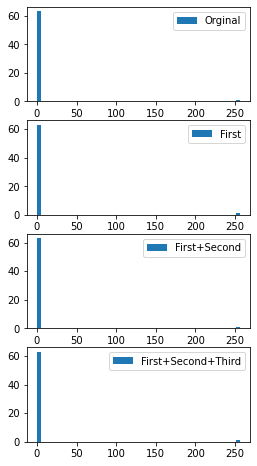

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

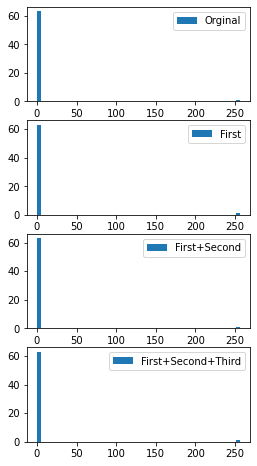

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

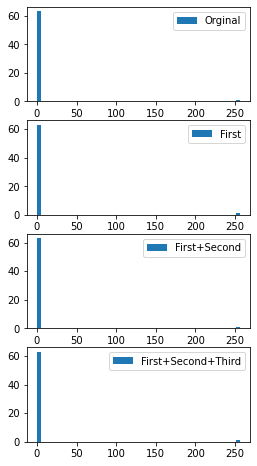

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

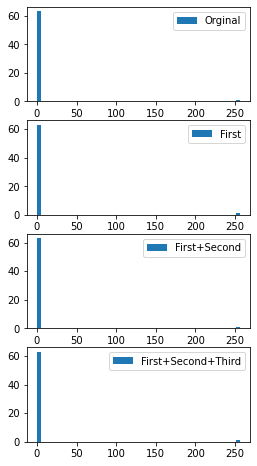

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

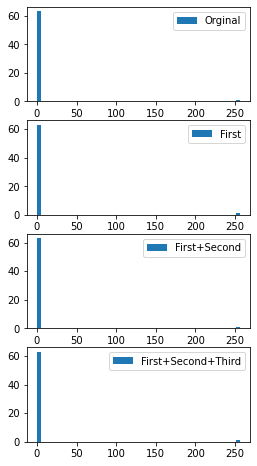

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

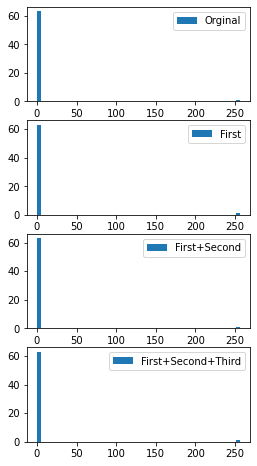

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

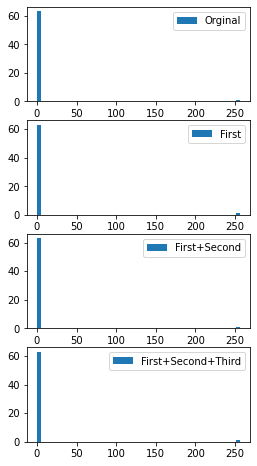

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

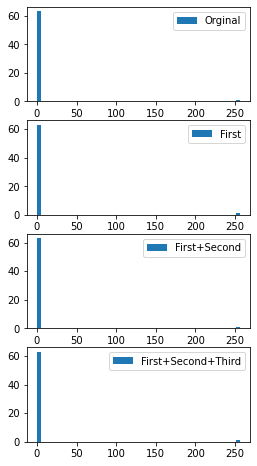

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

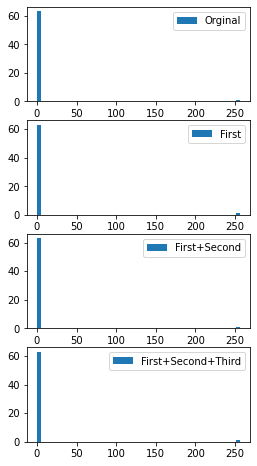

<IPython.core.display.Javascript object>

In [83]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*20) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):


        f = plt.figure(figsize=(4,8))
        ax = f.add_subplot(411)
        ax2 = f.add_subplot(412)
        ax3 = f.add_subplot(413)
        ax4 = f.add_subplot(414)



        ax.hist(out[0][1][i], bins=50,label='Orginal')
        ax.legend()

        ax2.hist(out[1][1][i], bins=50,label='First')
        ax2.legend()

        ax3.hist(out[2][1][i], bins=50,label='First+Second')
        ax3.legend()

        ax4.hist(out[3][1][i], bins=50,label='First+Second+Third')
        ax4.legend()
        plt.savefig('/content/drive/My Drive/LCNN/plot/4NNspectrum/'+str(i)+'.pdf')


    plt.show()

(array([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-6.26815336e-06,  5.11999512e+00,  1.02399960e+01,  1.53599977e+01,
         2.04799995e+01,  2.56000004e+01,  3.07200012e+01,  3.58400040e+01,
         4.09600029e+01,  4.60800056e+01,  5.12000084e+01,  5.63200073e+01,
         6.14400101e+01,  6.65600128e+01,  7.16800156e+01,  7.68000107e+01,
         8.19200134e+01,  8.70400162e+01,  9.21600189e+01,  9.72800217e+01,
         1.02400024e+02,  1.07520020e+02,  1.12640022e+02,  1.17760025e+02,
         1.22880028e+02,  1.28000031e+02,  1.33120026e+02,  1.38240036e+02,
         1.43360031e+02,  1.48480026e+02,  1.53600037e+02,  1.58720032e+02,
         1.63840042e+02,  1.68960037e+02,  1.74080032e+02,  1.79200043e+02,
         1.84320038e+02,  1.8944

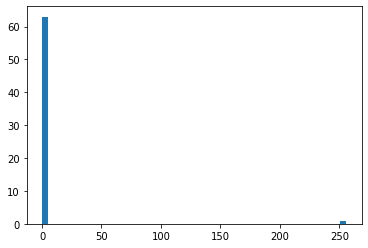

In [79]:
 plt.hist(out[1][1][2], bins=50,label='First')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

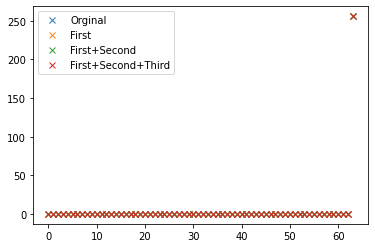

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

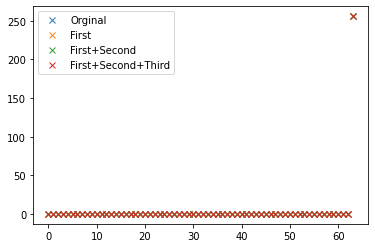

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

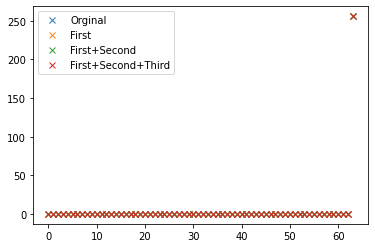

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

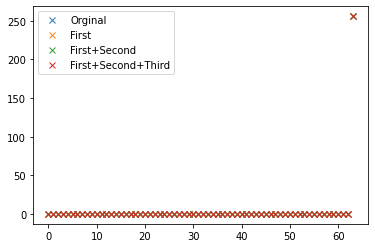

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

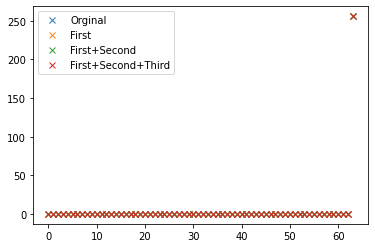

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

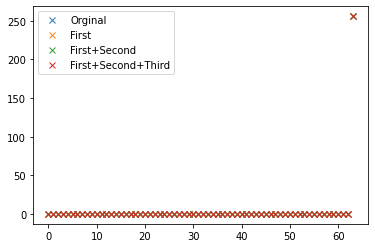

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

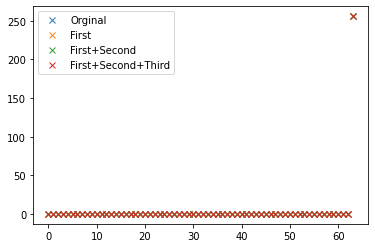

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

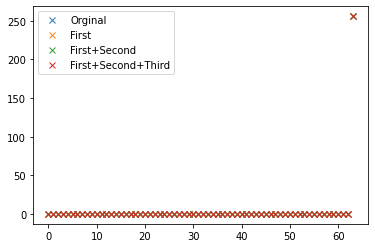

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

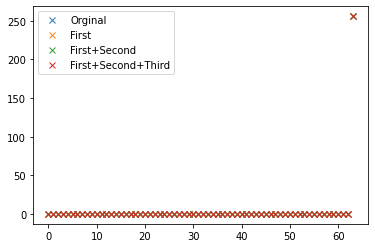

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

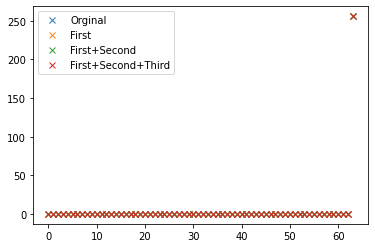

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

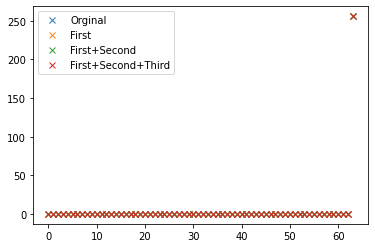

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

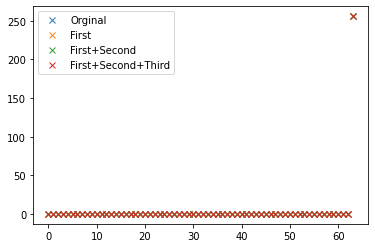

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

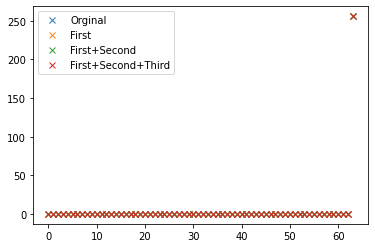

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

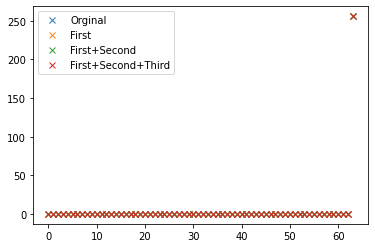

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

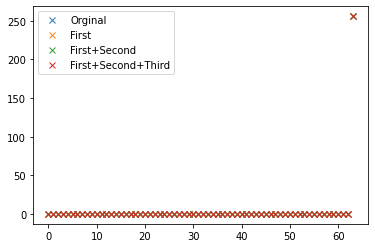

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

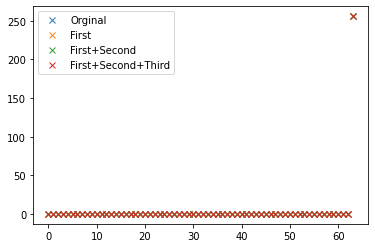

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

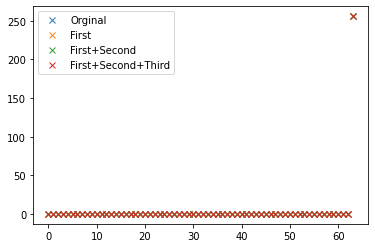

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

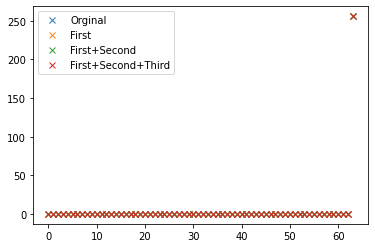

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

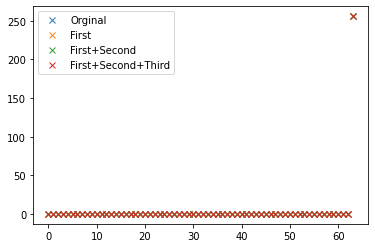

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

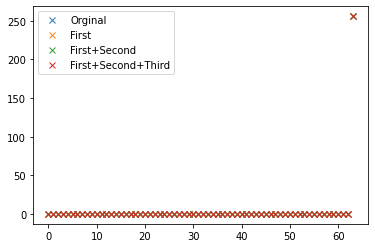

<IPython.core.display.Javascript object>

In [58]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*20) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):
        plt.plot(np.sort(out[0][1][i]),'x',label='Orginal')
        plt.plot(np.sort(out[1][1][i]),'x',label='First')
        plt.plot(np.sort(out[2][1][i]),'x',label='First+Second')
        plt.plot(np.sort(out[3][1][i]),'x',label='First+Second+Third')
        plt.legend()

    plt.show()

In [57]:
out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for prob in [0,1,2,3]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(40):
        if runsteps %2==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                image=images[i]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                labelo=outputs.clone()
                labelo[outputindex]=label[outputindex]
                loss = criterion(outputs, labelo).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pigrad=[]
                pindex=0
                deff=label[outputindex]-outputs[outputindex]
                for p in model.parameters():
                    Pigrad.append(p.grad.detach()/deff*10)
                for j in range(i):
                    image=images[j]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    labelo=outputs.clone()
                    labelo[outputindex]=label[outputindex]
                    loss = criterion(outputs, labelo).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pjgrad=[]
                    pjndex=0
                    deff=label[outputindex]-outputs[outputindex]
                    for p in model.parameters():
                        Pjgrad.append(p.grad.detach()/deff*10)
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                        H[i][j]=ij
                        H[j][i]=ij
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                    H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


        if prob>1 and runsteps==de:
            model.fc1.register_forward_hook(get_activation('fc1'))
            output = model(images)
            adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1) 
        if prob>2 and runsteps==2*de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])

0 0 0.10569465160369873
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
1 0 0.10569465160369873
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
2 0 0.10569465160369873
Adjusting Layer 2, Kernel Nodes: 134, Adptive Nodes66
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
3 0 0.10569465160369873
Adjusting Layer 2, Kernel Nodes: 134, Adptive Nodes66
Adjusting Layer 3, Kernel Nodes: 84, Adptive Nodes16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

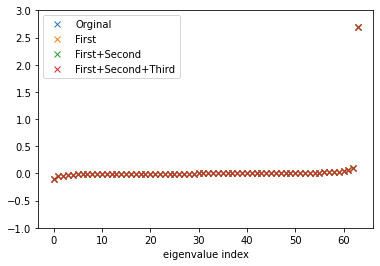

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

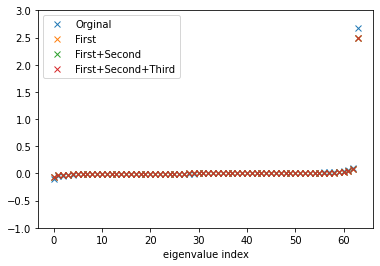

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

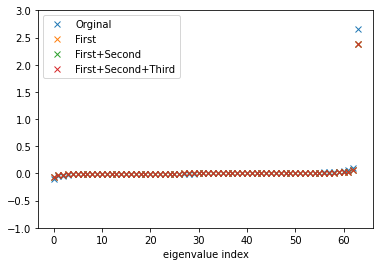

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

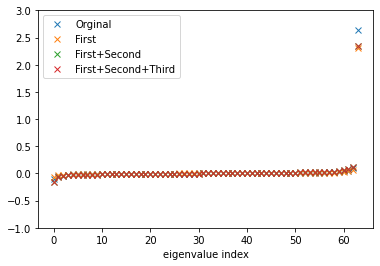

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

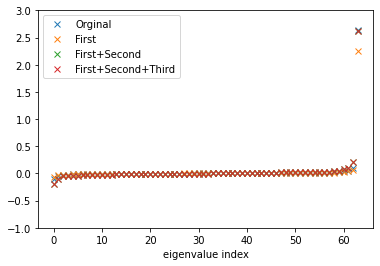

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

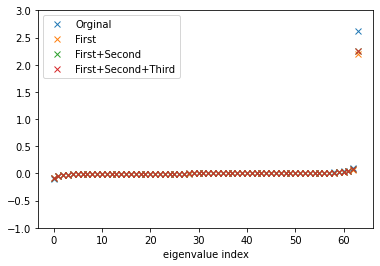

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

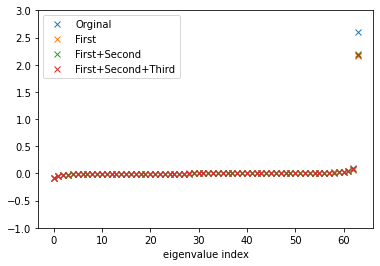

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

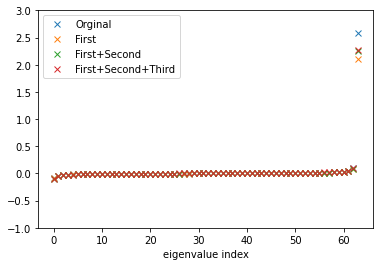

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

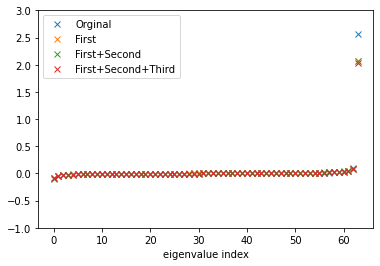

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

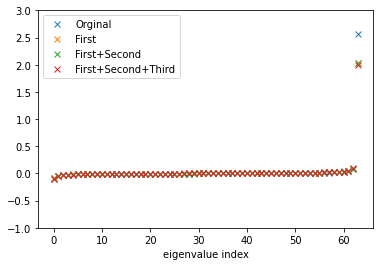

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

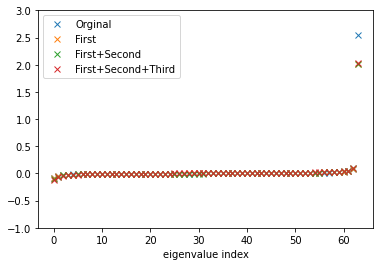

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

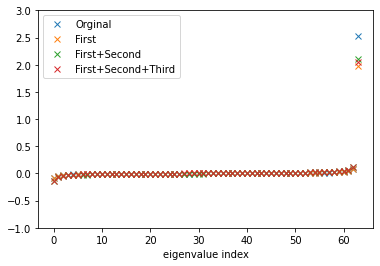

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

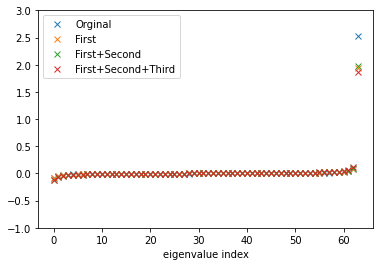

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

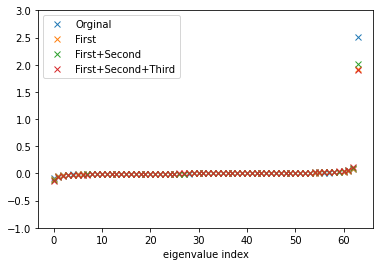

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

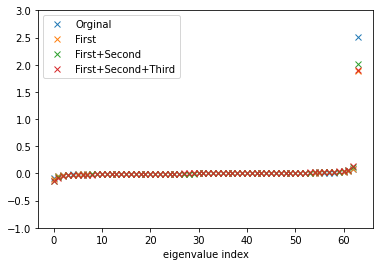

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

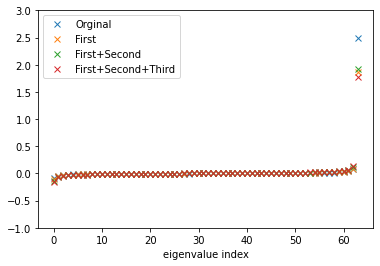

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

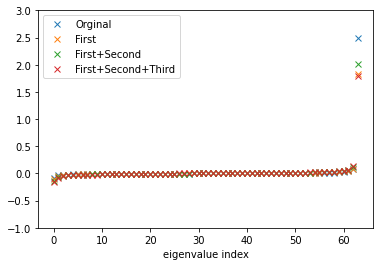

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

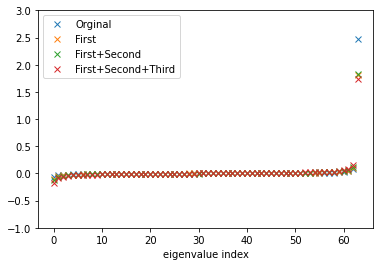

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

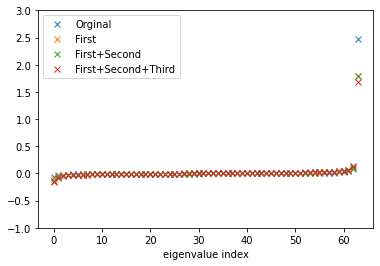

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

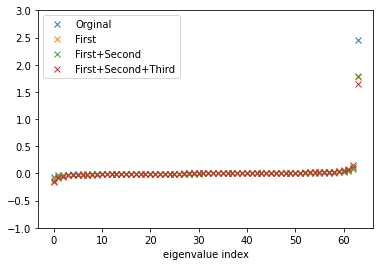

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*2) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):
        plt.plot(np.sort(out[0][1][i]),'x',label='Orginal')
        plt.plot(np.sort(out[1][1][i]),'x',label='First')
        plt.plot(np.sort(out[2][1][i]),'x',label='First+Second')
        plt.plot(np.sort(out[3][1][i]),'x',label='First+Second+Third')
        plt.legend()
        plt.xlabel('eigenvalue index')


    plt.show()

In [ ]:
out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for prob in [0,1,2,3]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=10
    for runsteps in range(1000*20):
        if runsteps %100000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach())
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[j]
                        loss = criterion(outputs, label).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach())
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


        if prob>1 and runsteps==de:
            model.fc1.register_forward_hook(get_activation('fc1'))
            output = model(images)
            adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1) 
        if prob>2 and runsteps==2*de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])


0 0 0.10569465160369873
0 100 0.08883868902921677
0 200 0.08253630250692368
0 300 0.07853171229362488
0 400 0.0750017985701561
0 500 0.07162363827228546
0 600 0.06835775077342987
0 700 0.0651361271739006
0 800 0.06191561371088028
0 900 0.058705300092697144
0 1000 0.05551088601350784
0 1100 0.052286017686128616
0 1200 0.04919316992163658
0 1300 0.04625272378325462
0 1400 0.04346584901213646
0 1500 0.04085369035601616
0 1600 0.038377583026885986
0 1700 0.03602243587374687
0 1800 0.033812444657087326
0 1900 0.031739242374897
0 2000 0.029801378026604652
0 2100 0.027987604960799217
0 2200 0.026305079460144043
0 2300 0.02473684959113598
0 2400 0.023278016597032547
0 2500 0.021914422512054443
0 2600 0.020642492920160294
0 2700 0.019460638985037804
0 2800 0.018361514434218407
0 2900 0.017331354320049286
0 3000 0.016357727348804474
0 3100 0.01543776411563158
0 3200 0.014558576047420502
0 3300 0.013734692707657814
0 3400 0.012954222038388252
0 3500 0.012214806862175465
0 3600 0.01151034235954284

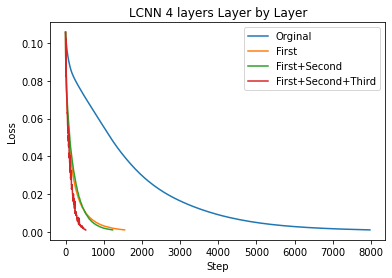

In [ ]:
plt.plot(out[0][0],'-',label='Orginal')
plt.plot(out[1][0],'-',label='First')
plt.plot(out[2][0],'-',label='First+Second')
plt.plot(out[3][0],'-',label='First+Second+Third')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/4layertt1.pdf')

In [99]:
out=[]

for prob in [0,1,2,3]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)

    if prob>0:
        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

    losslist=[]
    elist=[]
    de=10
    for runsteps in range(1000*20):
        if runsteps %5000000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach())
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[j]
                        loss = criterion(outputs, label).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach())
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)


        if prob>1 and runsteps==de:
            model.fc1.register_forward_hook(get_activation('fc1'))
            output = model(images)
            adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1) 
        if prob>2 and runsteps==de*2:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.01:
            break
    out.append([losslist,elist])

0 0 0.10569465160369873
0 100 0.08883868902921677
0 200 0.08253630250692368
0 300 0.07853171229362488
0 400 0.0750017985701561
0 500 0.07162363827228546
0 600 0.06835775077342987
0 700 0.0651361271739006
0 800 0.06191561371088028
0 900 0.058705300092697144
0 1000 0.05551088601350784
0 1100 0.052286017686128616
0 1200 0.04919316992163658
0 1300 0.04625272378325462
0 1400 0.04346584901213646
0 1500 0.04085369035601616
0 1600 0.038377583026885986
0 1700 0.03602243587374687
0 1800 0.033812444657087326
0 1900 0.031739242374897
0 2000 0.029801378026604652
0 2100 0.027987604960799217
0 2200 0.026305079460144043
0 2300 0.02473684959113598
0 2400 0.023278016597032547
0 2500 0.021914422512054443
0 2600 0.020642492920160294
0 2700 0.019460638985037804
0 2800 0.018361514434218407
0 2900 0.017331354320049286
0 3000 0.016357727348804474
0 3100 0.01543776411563158
0 3200 0.014558576047420502
0 3300 0.013734692707657814
0 3400 0.012954222038388252
0 3500 0.012214806862175465
0 3600 0.01151034235954284

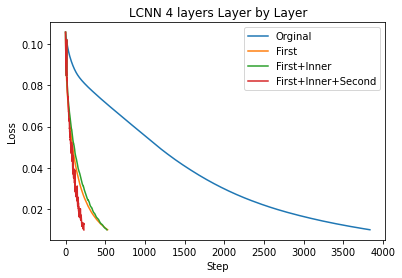

In [100]:
plt.plot(out[0][0],'-',label='Orginal')
plt.plot(out[1][0],'-',label='First')
plt.plot(out[2][0],'-',label='First+Inner')
plt.plot(out[3][0],'-',label='First+Inner+Second')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('LCNN 4 layers Layer by Layer')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.savefig('/content/drive/My Drive/LCNN/plot/4layertt1.pdf')

## compare coulped or not

In [5]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=0
    aclist=[]
    for runsteps in range(1000*20):
        if runsteps %10000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach())
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[j]
                        loss = criterion(outputs, label).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach())
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)
        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  

        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()
        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,elist,aclist])

outdec=out

0 0 0.10614407062530518
Accuracy: 9.0000 %
0 10 0.08856546878814697
Accuracy: 15.9600 %
0 20 0.08359610289335251
Accuracy: 24.6800 %
0 30 0.07867630571126938
Accuracy: 36.5200 %
0 40 0.07384074479341507
Accuracy: 44.4600 %
0 50 0.0690416619181633
Accuracy: 49.1100 %
0 60 0.06429379433393478
Accuracy: 50.1500 %
0 70 0.05968872457742691
Accuracy: 52.5700 %
0 80 0.05542271211743355
Accuracy: 53.7600 %
0 90 0.05142026022076607
Accuracy: 54.4400 %
0 100 0.047725778073072433
Accuracy: 55.4700 %
0 110 0.04431846737861633
Accuracy: 56.3100 %
0 120 0.041200242936611176
Accuracy: 56.8000 %
0 130 0.03834870830178261
Accuracy: 57.7700 %
0 140 0.035749245434999466
Accuracy: 58.5900 %
0 150 0.033384520560503006
Accuracy: 59.1300 %
0 160 0.03123164176940918
Accuracy: 59.5900 %
0 170 0.02926558256149292
Accuracy: 59.9600 %
0 180 0.027460336685180664
Accuracy: 60.4600 %
0 190 0.02579681947827339
Accuracy: 61.0100 %
0 200 0.02426004223525524
Accuracy: 61.4600 %
0 210 0.02283414453268051
Accuracy: 61.830

In [6]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out
out=[]
for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=0
    aclist=[]
    for runsteps in range(1000*20):
        if runsteps %10000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                    image=images[i]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pigrad=[]
                    pindex=0
                    for p in model.parameters():
                        Pigrad.append(p.grad.detach())
                    for j in range(i):
                        image=images[j]
                        outputs = model(image).to(device)
                        label=labels[j]
                        loss = criterion(outputs, label).to(device)
                        optimizer.zero_grad()
                        loss.backward()
                        Pjgrad=[]
                        pjndex=0
                        for p in model.parameters():
                            Pjgrad.append(p.grad.detach())
                        with torch.no_grad():
                            ij=0
                            for iii in range(numberparameter):
                                ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                            H[i][j]=ij
                            H[j][i]=ij
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                        H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)
        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  

        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()
        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,elist,aclist])
outc=out

0 0 0.10569465160369873
Accuracy: 14.4000 %
0 10 0.09537862241268158
Accuracy: 22.1000 %
0 20 0.08707159012556076
Accuracy: 25.4300 %
0 30 0.08271323889493942
Accuracy: 24.9100 %
0 40 0.07955865561962128
Accuracy: 34.8000 %
0 50 0.07635679095983505
Accuracy: 43.7900 %
0 60 0.07333999872207642
Accuracy: 46.2200 %
0 70 0.07033994048833847
Accuracy: 47.6600 %
0 80 0.06732103228569031
Accuracy: 48.6200 %
0 90 0.0643378347158432
Accuracy: 49.5900 %
0 100 0.06132609769701958
Accuracy: 50.7800 %
0 110 0.058310043066740036
Accuracy: 51.6700 %
0 120 0.0553305521607399
Accuracy: 52.4300 %
0 130 0.0524117536842823
Accuracy: 53.0700 %
0 140 0.04954929277300835
Accuracy: 53.6800 %
0 150 0.046786244958639145
Accuracy: 54.2000 %
0 160 0.04413112998008728
Accuracy: 54.7800 %
0 170 0.04161537438631058
Accuracy: 55.3300 %
0 180 0.03924454748630524
Accuracy: 55.8000 %
0 190 0.037016455084085464
Accuracy: 56.2100 %
0 200 0.03492647036910057
Accuracy: 56.7600 %
0 210 0.03296356648206711
Accuracy: 57.3500 %

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

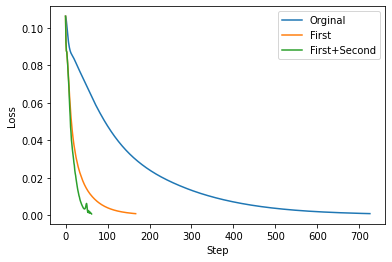

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

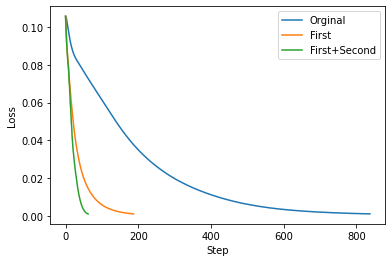

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
tb = widgets.TabBar(['dec', 'c'])
with tb.output_to('dec'):
    plt.plot(outdec[0][0],'-',label='Orginal')
    plt.plot(outdec[1][0],'-',label='First')
    plt.plot(outdec[2][0],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

with tb.output_to('c'):
    plt.plot(outc[0][0],'-',label='Orginal')
    plt.plot(outc[1][0],'-',label='First')
    plt.plot(outc[2][0],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

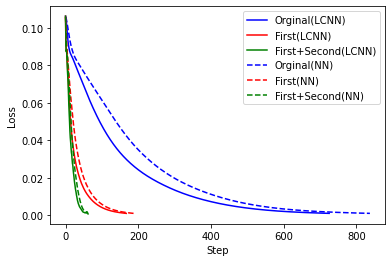

In [8]:
    plt.plot(outdec[0][0],'-',color='blue',label='Orginal(LCNN)')
    plt.plot(outdec[1][0],'-',color='red',label='First(LCNN)')
    plt.plot(outdec[2][0],'-',color='green',label='First+Second(LCNN)')
    plt.plot(outc[0][0],'--',color='blue',label='Orginal(NN)')
    plt.plot(outc[1][0],'--',color='red',label='First(NN)')
    plt.plot(outc[2][0],'--',color='green',label='First+Second(NN)')

    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.savefig('/content/drive/My Drive/LCNN/plot/compare2.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

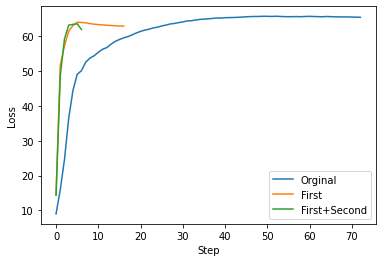

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

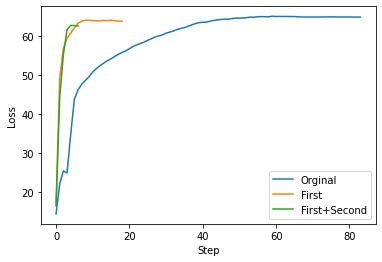

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
tb = widgets.TabBar(['dec', 'c'])
with tb.output_to('dec'):
    plt.plot(outdec[0][2],'-',label='Orginal')
    plt.plot(outdec[1][2],'-',label='First')
    plt.plot(outdec[2][2],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

with tb.output_to('c'):
    plt.plot(outc[0][2],'-',label='Orginal')
    plt.plot(outc[1][2],'-',label='First')
    plt.plot(outc[2][2],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

No handles with labels found to put in legend.


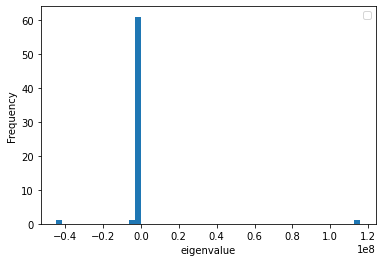

In [26]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out
eigenvaluepolt=True
outputindex=1     
if eigenvaluepolt:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)

    H=torch.zeros([batch_size,batch_size])
    numberparameter=len(model.state_dict())
    for i in range(batch_size):
            image=images[i]
            outputs = model(image).to(device)
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            
            Pigrad=[]
            pindex=0
            for p in model.parameters():
                Pigrad.append(p.grad.detach())
            for j in range(i):
                image=images[i]
                outputs = model(image).to(device)[outputindex]
                outputs.backward(torch.ones_like(outputs))
                Pjgrad=[]
                pjndex=0
                for p in model.parameters():
                    Pjgrad.append(p.grad.detach())
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                    H[i][j]=ij
                    H[j][i]=ij
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                H[i][i]=ij
    eig=torch.eig(H)           
    eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
    plt.hist(eigenvaluem, bins=50) 
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('eigenvalue')


In [20]:
torch.sum(torch.tensor([[1,2],[1,2]])*torch.tensor([[1,2],[1,2]]))

tensor(10)

In [ ]:
G matrix

## G matrix

In [4]:
def iterstep(i):
    for k in range(i):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
def onestep():
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

In [5]:
out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for prob in [0,1,2,3]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(400):
        if runsteps %20==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())



            for i in range(batch_size):
                image=images[i]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                loss = criterion(outputs, label).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pigrad=[]
                pindex=0
                for p in model.parameters():
                    Pigrad.append(p.grad.detach())
                for j in range(i):
                    image=images[j]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pjgrad=[]
                    pjndex=0
                    for p in model.parameters():
                        Pjgrad.append(p.grad.detach())
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                        H[i][j]=ij
                        H[j][i]=ij
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                    H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)


        if prob>1 and runsteps==de:
            model.fc1.register_forward_hook(get_activation('fc1'))
            output = model(images)
            adjust(model,activation['fc'+str(1)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=2,oflag=1) 
        if prob>2 and runsteps==2*de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])

0 0 0.10569465160369873
0 100 0.08883868902921677
0 200 0.08253630250692368
0 300 0.07853171229362488
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
1 0 0.10569465160369873
1 100 0.04708847403526306
1 200 0.029492726549506187
1 300 0.02024618349969387
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
2 0 0.10569465160369873
Adjusting Layer 2, Kernel Nodes: 134, Adptive Nodes66
2 100 0.0484742596745491
2 200 0.0314626507461071
2 300 0.02139142155647278
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
3 0 0.10569465160369873
Adjusting Layer 2, Kernel Nodes: 134, Adptive Nodes66
Adjusting Layer 3, Kernel Nodes: 84, Adptive Nodes16
3 100 0.03605430945754051
3 200 0.014082560315728188
3 300 0.0079031465575099


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

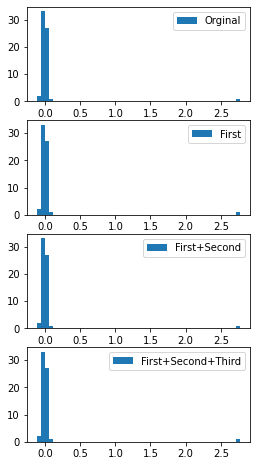

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

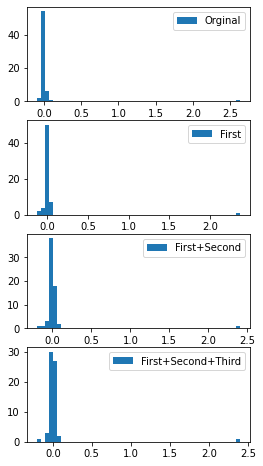

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

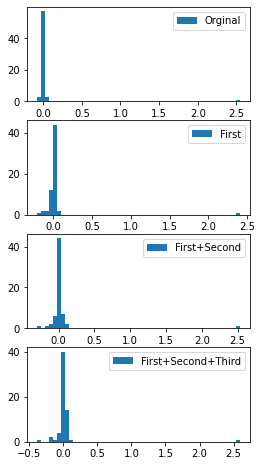

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

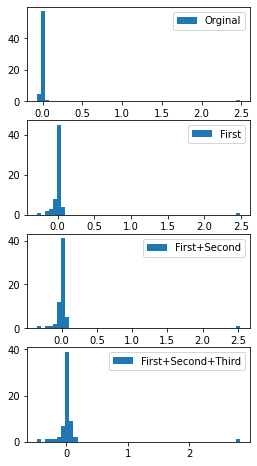

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

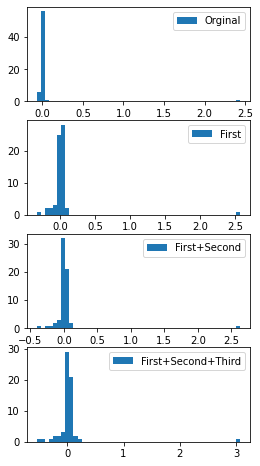

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

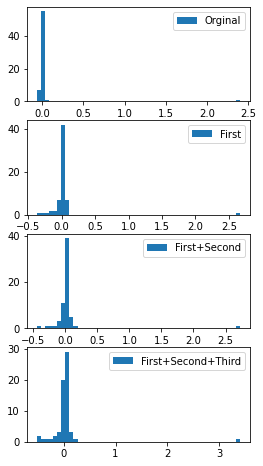

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

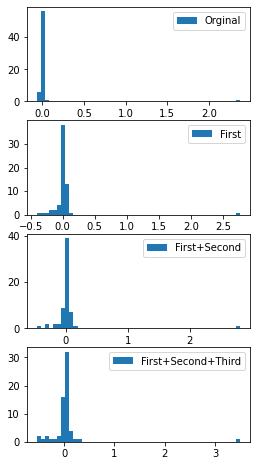

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

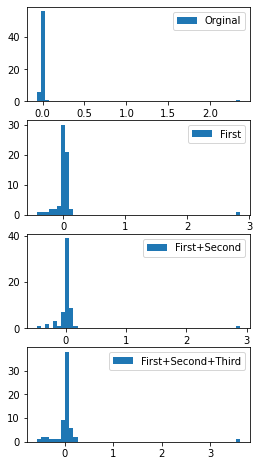

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

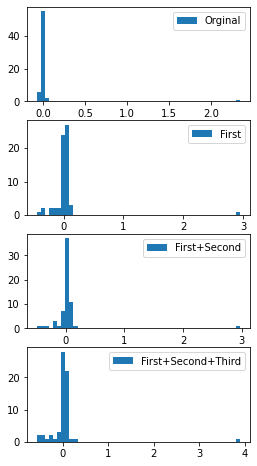

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

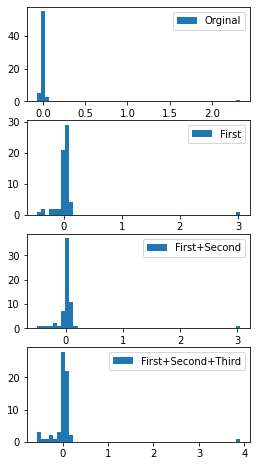

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

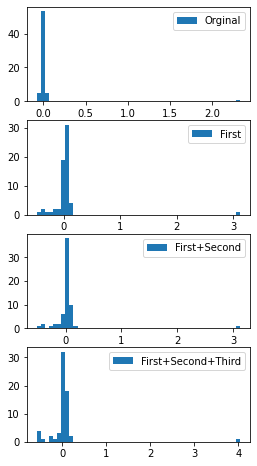

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

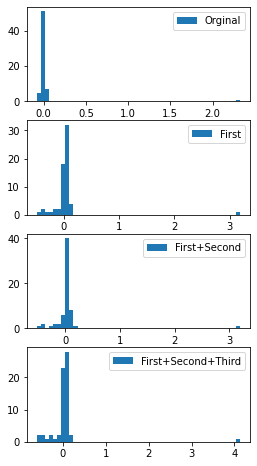

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

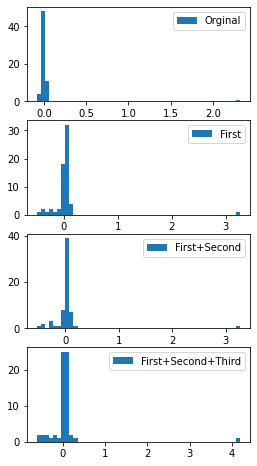

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

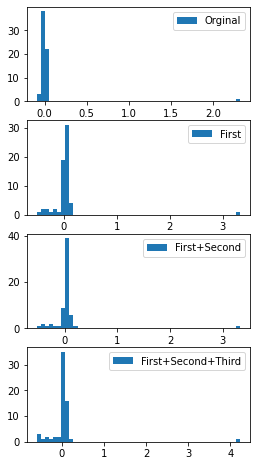

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

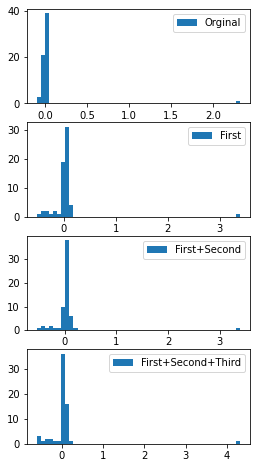

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

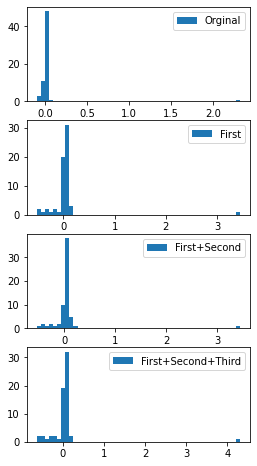

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

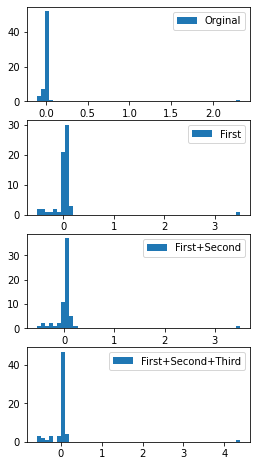

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

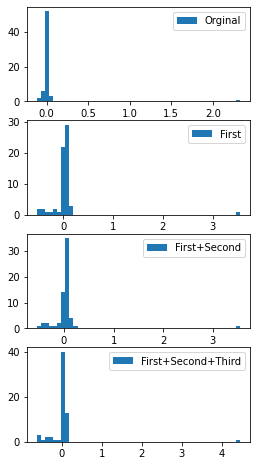

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

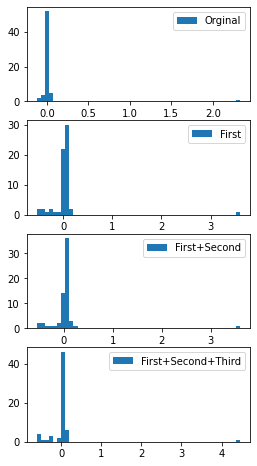

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

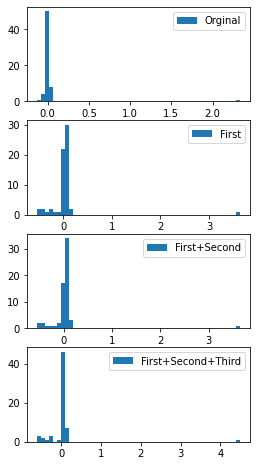

<IPython.core.display.Javascript object>

In [6]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*20) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):


        f = plt.figure(figsize=(4,8))
        ax = f.add_subplot(411)
        ax2 = f.add_subplot(412)
        ax3 = f.add_subplot(413)
        ax4 = f.add_subplot(414)



        ax.hist(out[0][1][i], bins=50,label='Orginal')
        ax.legend()

        ax2.hist(out[1][1][i], bins=50,label='First')
        ax2.legend()

        ax3.hist(out[2][1][i], bins=50,label='First+Second')
        ax3.legend()

        ax4.hist(out[3][1][i], bins=50,label='First+Second+Third')
        ax4.legend()
        plt.savefig('/content/drive/My Drive/LCNN/plot/4NNspectrum/G'+str(i)+'.pdf')


    plt.show()

In [7]:
def iterstep(i):
    for k in range(i):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
def onestep():
    outputs = model(images).to(device)
    loss = criterion(outputs, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

In [8]:
out=[]

for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=5
    for runsteps in range(400):
        if runsteps %20==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())


            for i in range(batch_size):
                image=images[i]
                outputs = model(image).to(device)
                label=labels[i].to(device)
                loss = criterion(outputs, label).to(device)
                optimizer.zero_grad()
                loss.backward()
                Pigrad=[]
                pindex=0
                for p in model.parameters():
                    Pigrad.append(p.grad.detach())
                for j in range(i):
                    image=images[j]
                    outputs = model(image).to(device)
                    label=labels[i].to(device)
                    loss = criterion(outputs, label).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    Pjgrad=[]
                    pjndex=0
                    for p in model.parameters():
                        Pjgrad.append(p.grad.detach())
                    with torch.no_grad():
                        ij=0
                        for iii in range(numberparameter):
                            ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                        H[i][j]=ij
                        H[j][i]=ij
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                    H[i][i]=ij
            eig=torch.eig(H)           
            eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
            elist.append(eigenvaluem)


        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)



        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  


        lo=onestep()
        losslist.append(lo)
        if runsteps%100==0:
            print(prob,runsteps,lo)
        if lo<0.001:
            break
    out.append([losslist,elist])

0 0 0.10614407062530518
0 100 0.0838378295302391
0 200 0.07799194008111954
0 300 0.07230466604232788
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
1 0 0.10614407062530518
1 100 0.03473510965704918
1 200 0.020902398973703384
1 300 0.014074272476136684
Adjusting Layer 1, Kernel Nodes: 646, Adptive Nodes154
2 0 0.10614407062530518
Adjusting Layer 3, Kernel Nodes: 94, Adptive Nodes6
2 100 0.021579252555966377
2 200 0.007401715498417616
2 300 0.0034927332308143377


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

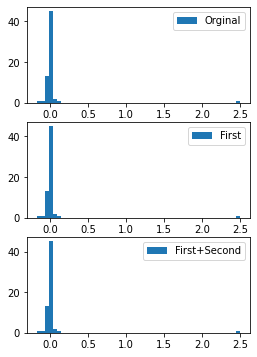

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

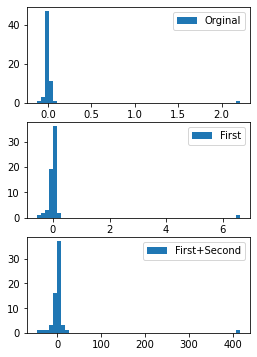

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

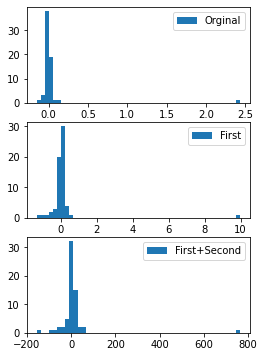

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

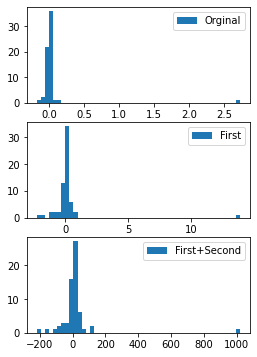

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

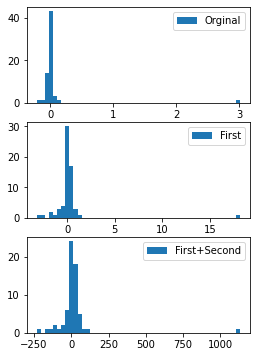

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

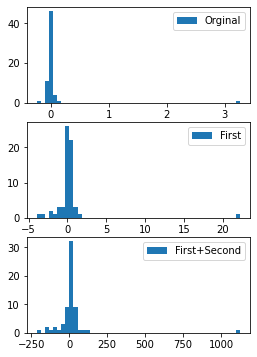

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

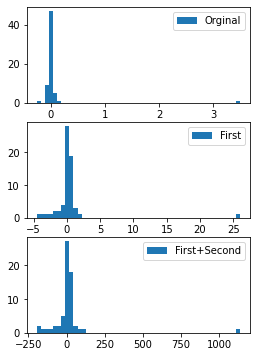

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

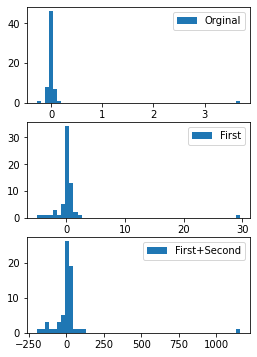

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

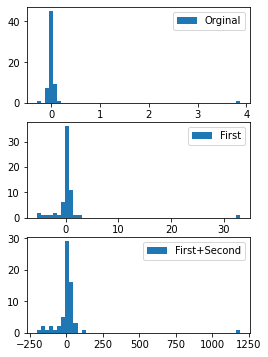

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

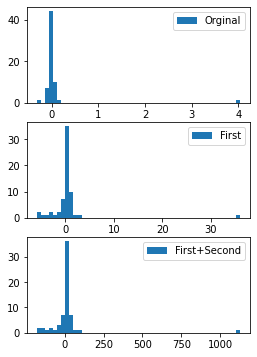

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

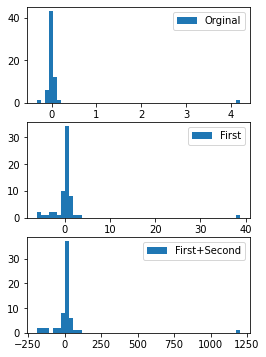

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

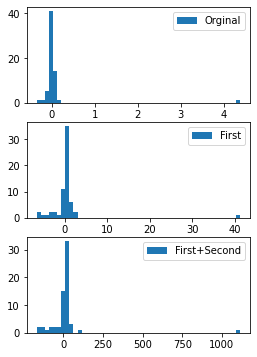

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

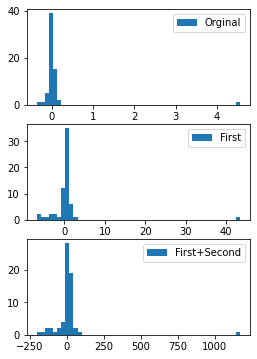

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

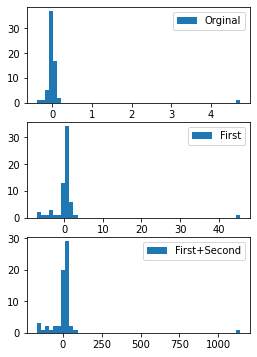

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

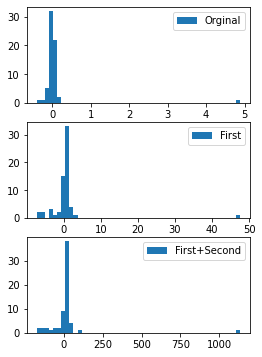

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

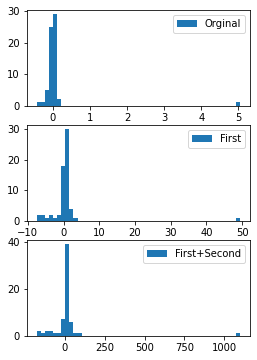

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

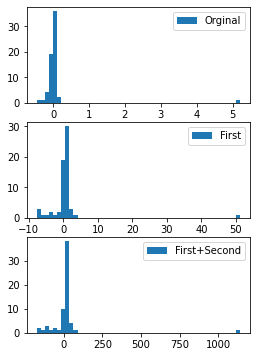

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

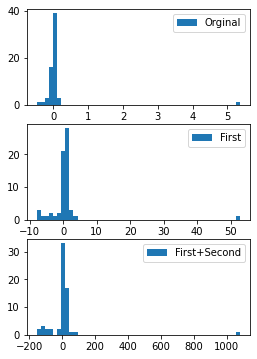

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

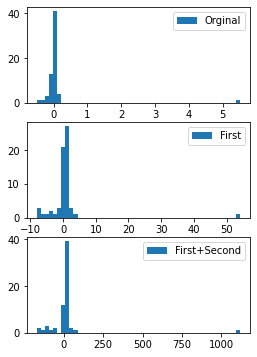

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

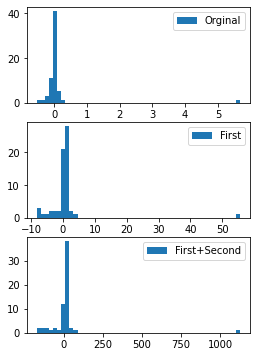

<IPython.core.display.Javascript object>

In [9]:
from google.colab import widgets
pl=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
tb = widgets.TabBar([str(i*20) for i in pl])
for i in range(20):
  # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i):


        f = plt.figure(figsize=(4,6))
        ax = f.add_subplot(311)
        ax2 = f.add_subplot(312)
        ax3 = f.add_subplot(313)



        ax.hist(out[0][1][i], bins=50,label='Orginal')
        ax.legend()

        ax2.hist(out[1][1][i], bins=50,label='First')
        ax2.legend()

        ax3.hist(out[2][1][i], bins=50,label='First+Second')
        ax3.legend()

        plt.savefig('/content/drive/My Drive/LCNN/plot/4LCNNspectrum/G'+str(i)+'.pdf')


    plt.show()